In [343]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from datetime import datetime
import tensorflow as tf
from tqdm import tqdm_notebook as tqdm
import collections

In [344]:
v10_cb = pd.read_csv("v10_cb.csv")
v10_p4 = pd.read_csv("v10_p4.csv")

v10_cb["timestamp"]= v10_cb["timestamp"].apply(lambda x: datetime.fromtimestamp(x/1000))
v10_p4["timestamp"]= v10_p4["timestamp"].apply(lambda x: datetime.fromtimestamp(x/1000))

v10_cb["timestamp"]= v10_cb["timestamp"].apply(lambda x: x - v10_cb["timestamp"][0])
v10_p4["timestamp"]= v10_p4["timestamp"].apply(lambda x: x - v10_p4["timestamp"][0])

v10_cb["timestamp"] = v10_cb["timestamp"].dt.seconds + v10_cb["timestamp"].dt.microseconds/10e6
v10_p4["timestamp"] = v10_p4["timestamp"].dt.seconds + v10_p4["timestamp"].dt.microseconds/10e6

In [345]:
dt_cb = v10_cb["timestamp"]
dt_p4 = v10_p4["timestamp"]

cb = v10_cb["val"]
p4 = v10_p4["val"]

In [346]:
np.min(cb)

0.280737

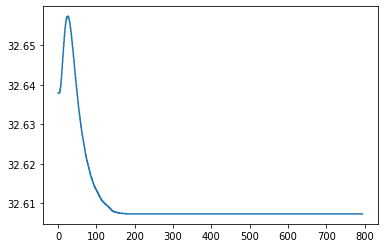

In [347]:
plt.plot(dt_p4,p4)
plt.show()

In [348]:
epochs = 50000
optimizer = tf.keras.optimizers.SGD(learning_rate=10e-2, momentum= 0.95)
# t0 = tf.Variable(tf.random.uniform((1,),minval=-100, maxval=100, name='t0'))
# t1 = tf.Variable(tf.random.uniform((1,),minval=0, maxval=100, name='t1'))
# t2 = tf.Variable(tf.random.uniform((1,),minval=0, maxval=100, name='t2'))

t0 = tf.Variable(0.0, name='t0')
t1 = tf.Variable(1.0, name='t1', constraint = lambda z: tf.clip_by_value(z, 0.0, 100.0))
t2 = tf.Variable(2.0, name='t2', constraint = lambda z: tf.clip_by_value(z, 0.0, 100.0))

def loss_compute(y_true, y_pred):
    return tf.square(y_true - y_pred)

patience = 20
delta = 1
loss_history = collections.deque(maxlen=patience + 1)

# print(t0)
# print(t1)
# print(t2)
# print(" ")
pbar = tqdm(range(epochs))

for epoch in pbar:
    loss = 0
    time = tf.constant(dt_p4,dtype=tf.float32)
    y = tf.constant(p4,dtype = tf.float32)

    with tf.GradientTape(persistent=True) as tape:
        e1 = tf.exp(-time/t1)
        e2 = tf.exp(-time/t2)
        c1 = tf.divide(tf.subtract(t0,t1),tf.add(tf.subtract(t1,t2),tf.constant(10e-3)))
        c2 = tf.divide(tf.subtract(t0,t2),tf.add(tf.subtract(t2,t1),tf.constant(10e-3)))
        h1 = tf.multiply(c1,tf.cast(e1, tf.float32))
        h2 = tf.multiply(c2,tf.cast(e2, tf.float32))
        h = 1 + h1 + h2
        y_ = p4[0]+tf.multiply(p4[-1:]-p4[0],h)
        loss1 = loss_compute(y, y_)
        loss = tf.reduce_sum(loss1)

        loss_history.append(loss)

        if tf.math.is_nan(c1):
            raise Exception("NaN")
        
        # print(e1," , ", e2," , ",c1," , ",c2," , ",h1," , ",h2)
        pbar.set_description('Training Loss: %.3f' % 
                                 loss.numpy())

    gradients = tape.gradient(loss,[t0,t1, t2])
    optimizer.apply_gradients(zip(gradients, [t0,t1,t2]))

    if len(loss_history) > patience:
        if loss_history.popleft()*delta < min(loss_history):
            print(f'\nEarly stopping. No improvement of more than {delta:.5%} in '
                  f'validation loss in the last {patience} epochs.')
            break
    # print(gradients)
    # print(" ")
    # print(t0)
    # print(t1)
    # print(t2)
    # print(" ")

C:\Users\Refa\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50000 [00:00<?, ?it/s]

KeyboardInterrupt: 

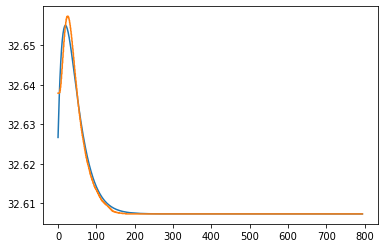

In [ ]:
e1 = tf.exp(-dt_p4/t1)
e2 = tf.exp(-dt_p4/t2)
c1 = tf.divide(tf.subtract(t0,t1),tf.add(tf.subtract(t1,t2),tf.constant(10e-3)))
c2 = tf.divide(tf.subtract(t0,t2),tf.add(tf.subtract(t2,t1),tf.constant(10e-3)))
h1 = tf.multiply(c1,tf.cast(e1, tf.float32))
h2 = tf.multiply(c2,tf.cast(e2, tf.float32))
h = 1 + h1 + h2
y_ = p4[0]+tf.multiply(p4[-1:]-p4[0],h)
plt.plot(dt_p4,y_)
plt.plot(dt_p4,p4)
plt.show()

In [ ]:
print(t0)
print(t1)
print(t2)
print(loss)

<tf.Variable 't0:0' shape=() dtype=float32, numpy=-60.06857>
<tf.Variable 't1:0' shape=() dtype=float32, numpy=22.492022>
<tf.Variable 't2:0' shape=() dtype=float32, numpy=24.627726>
tf.Tensor(0.009129043, shape=(), dtype=float32)


In [356]:
epochs = 50000
optimizer = tf.keras.optimizers.SGD(learning_rate=10e-2, momentum= 0.95)

ta = tf.Variable(-1.0, name='ta')
tb = tf.Variable(-1.0, name='tb')
t1 = tf.Variable(1.0, name='t1', constraint = lambda z: tf.clip_by_value(z, 0.0, 1000.0))
t2 = tf.Variable(2.0, name='t2', constraint = lambda z: tf.clip_by_value(z, 0.0, 1000.0))
t3 = tf.Variable(3.0, name='t3', constraint = lambda z: tf.clip_by_value(z, 0.0, 1000.0))

def loss_compute(y_true, y_pred):
    return tf.square(y_true - y_pred)

patience = 20
delta = 1
loss_history = collections.deque(maxlen=patience + 1)

pbar = tqdm(range(epochs))

for epoch in pbar:
    loss = 0

    time = tf.constant(dt_cb,dtype=tf.float32)
    y = tf.constant(cb,dtype = tf.float32)

    with tf.GradientTape(persistent=True) as tape:
        e1 = tf.exp(-time/t1)
        e2 = tf.exp(-time/t2)
        e3 = tf.exp(-time/t3)
        a1 = tf.multiply(tf.subtract(ta,t1),tf.subtract(tb,t1))
        a2 = tf.multiply(tf.subtract(ta,t2),tf.subtract(tb,t2))
        a3 = tf.multiply(tf.subtract(ta,t3),tf.subtract(tb,t3))
        c1 = tf.divide(a1,tf.multiply(tf.subtract(t1,t2),tf.subtract(t1,t3)))
        c2 = tf.divide(a2,tf.multiply(tf.subtract(t1,t2),tf.subtract(t2,t3)))
        c3 = tf.divide(a3,tf.multiply(tf.subtract(t1,t3),tf.subtract(t3,t2)))
        h1 = tf.multiply(c1,tf.cast(e1, tf.float32))
        h2 = tf.multiply(c2,tf.cast(e2, tf.float32))
        h3 = tf.multiply(c3,tf.cast(e3, tf.float32))
        h = 1 + h1 + h2 + h3
        y_ = cb[0]+tf.multiply(cb[-1:]-cb[0],h)
        loss1 = 20*loss_compute(y, y_)
        loss = tf.reduce_sum(loss1)
        loss_history.append(loss)
        if tf.math.is_nan(loss):
            raise Exception("NaN")
        
    pbar.set_description('Training Loss: %.10f' % 
                          loss.numpy())

    gradients = tape.gradient(loss,[ta,tb, t1, t2, t3])
    optimizer.apply_gradients(zip(gradients, [ta, tb, t1,t2, t3]))

    if len(loss_history) > patience:
        if loss_history.popleft()*delta < min(loss_history):
            print(f'\nEarly stopping. No improvement of more than {delta:.5%} in '
                  f'validation loss in the last {patience} epochs.')
            break
    # print(gradients)

C:\Users\Refa\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50000 [00:00<?, ?it/s]

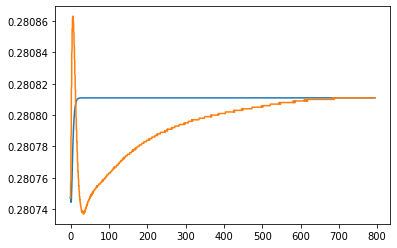

In [359]:
# ta = tf.Variable(-40.73180073, name='ta')
# tb = tf.Variable(-40.73187408, name='tb')
# t1 = tf.Variable(125.7752081, name='t1', constraint = lambda z: tf.clip_by_value(z, 0.0, 1000.0))
# t2 = tf.Variable(5.639043069, name='t2', constraint = lambda z: tf.clip_by_value(z, 0.0, 1000.0))
# t3 = tf.Variable(5.639039979, name='t3', constraint = lambda z: tf.clip_by_value(z, 0.0, 1000.0))

e1 = tf.exp(-time/t1)
e2 = tf.exp(-time/t2)
e3 = tf.exp(-time/t3)
a1 = tf.multiply(tf.subtract(ta,t1),tf.subtract(tb,t1))
a2 = tf.multiply(tf.subtract(ta,t2),tf.subtract(tb,t2))
a3 = tf.multiply(tf.subtract(ta,t3),tf.subtract(tb,t3))
c1 = tf.divide(a1,tf.multiply(tf.subtract(t1,t2),tf.subtract(t1,t3)))
c2 = tf.divide(a2,tf.multiply(tf.subtract(t1,t2),tf.subtract(t2,t3)))
c3 = tf.divide(a3,tf.multiply(tf.subtract(t1,t3),tf.subtract(t3,t2)))
h1 = tf.multiply(c1,tf.cast(e1, tf.float32))
h2 = tf.multiply(c2,tf.cast(e2, tf.float32))
h3 = tf.multiply(c3,tf.cast(e3, tf.float32))
h = 1 - h1 + h2 + h3
y_ = cb[0]+tf.multiply(cb[-1:]-cb[0],h)
plt.plot(dt_cb,y_)
plt.plot(dt_cb,cb)
plt.show()

In [360]:
print(ta)
print(tb)
print(t1)
print(t2)
print(t3)
print(loss.numpy())

<tf.Variable 'ta:0' shape=() dtype=float32, numpy=-0.7096263>
<tf.Variable 'tb:0' shape=() dtype=float32, numpy=-0.7096263>
<tf.Variable 't1:0' shape=() dtype=float32, numpy=0.36969757>
<tf.Variable 't2:0' shape=() dtype=float32, numpy=2.0426188>
<tf.Variable 't3:0' shape=() dtype=float32, numpy=2.9958913>
0.00010091155


2.784847e-05